# Installations

In [ ]:
# Install OpenCV with Contrib modules
!pip install opencv-contrib-python

# Install Open3D for 3D data processing
!pip install open3d

# (Optional) Upgrade NumPy to the latest version
!pip install --upgrade numpy

# (Optional) Upgrade Matplotlib to the latest version
!pip install --upgrade matplotlib

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 44.1 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 985.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 19.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Fou

# Import statements

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import pickle

# Global variables

In [26]:
# Define the path to your stereo images
stereo_images_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/Our 3D Construction/Files/Stereo images'

# Filenames of the stereo images
filenames = [
    'SideA_LeftCam.jpg', 'SideA_RightCam.jpg',
    'SideB_LeftCam.jpg', 'SideB_RightCam.jpg',
    'SideC_LeftCam.jpg', 'SideC_RightCam.jpg',
    'SideD_LeftCam.jpg', 'SideD_RightCam.jpg'
]

# Define the path to your calibration images
calibration_images_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/Our 3D Construction/Files/Checkerboard/Large checkerboard/Matched total exposures'

# Filenames of the calibration images
calibration_filenames = [
    'Calibration_A_LC.jpg', 'Calibration_A_RC.jpg',
    'Calibration_B_LC.jpg', 'Calibration_B_RC.jpg',
    'Calibration_C_LC.jpg', 'Calibration_C_RC.jpg',
    'Calibration_D_LC.jpg', 'Calibration_D_RC.jpg',
    'Calibration_E_LC.jpg', 'Calibration_E_RC.jpg'
]

In [ ]:
# Define the scaling percentage for resizing images
scale_percent = 25  # Adjust as needed (e.g., 25%, 50%)

# Functions

In [ ]:
# A function to resize images
def resize_image(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)
    return resized_image

In [ ]:
# Display the images
def display_images(images, titles):
    plt.figure(figsize=(20, 10))
    for i, img in enumerate(images):
        plt.subplot(2, 4, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Program start

## Preliminaries

### Mount Google Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Retrieve stereo images

In [ ]:
# Load and resize the images
stereo_images = []
for filename in filenames:
    image_path = os.path.join(stereo_images_path, filename)
    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        # Resize the image
        img_resized = resize_image(img, scale_percent)
        stereo_images.append(img_resized)
    else:
        print(f"Error: {filename} not found at {image_path}")

### Display stereo images

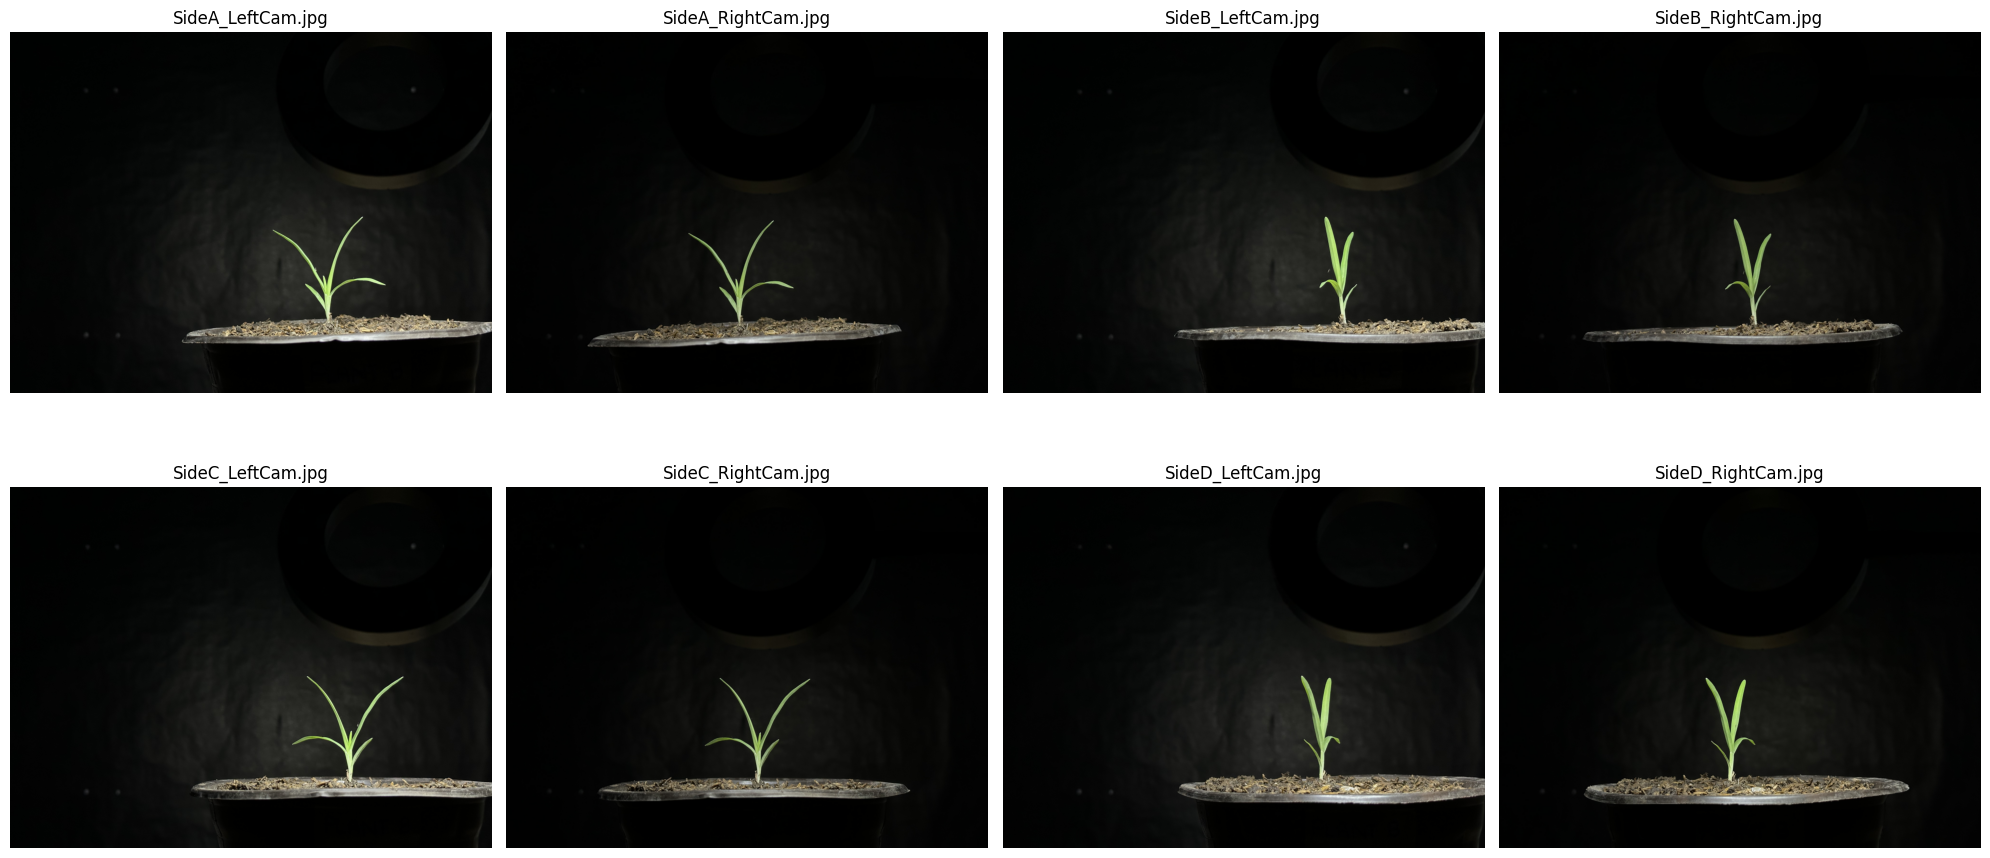

In [ ]:
titles = filenames
display_images(stereo_images, titles)

## Camera Calibration, and Image Rectification

Error: Chessboard corners not found in calibration image pair 1.


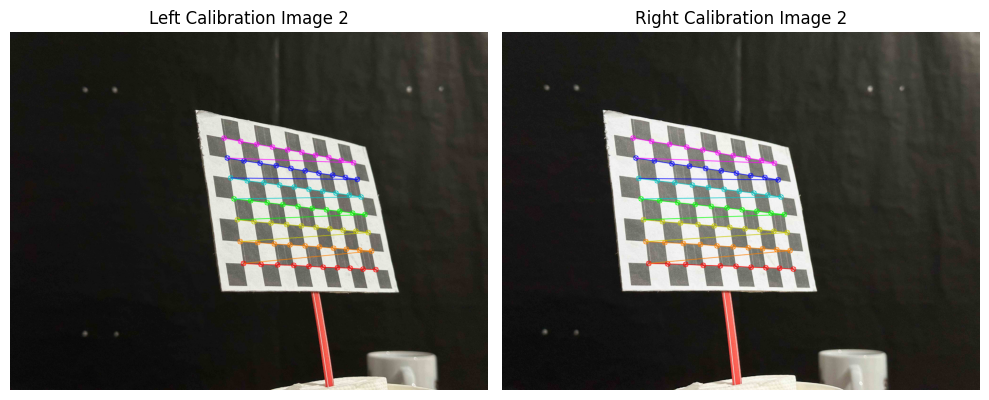

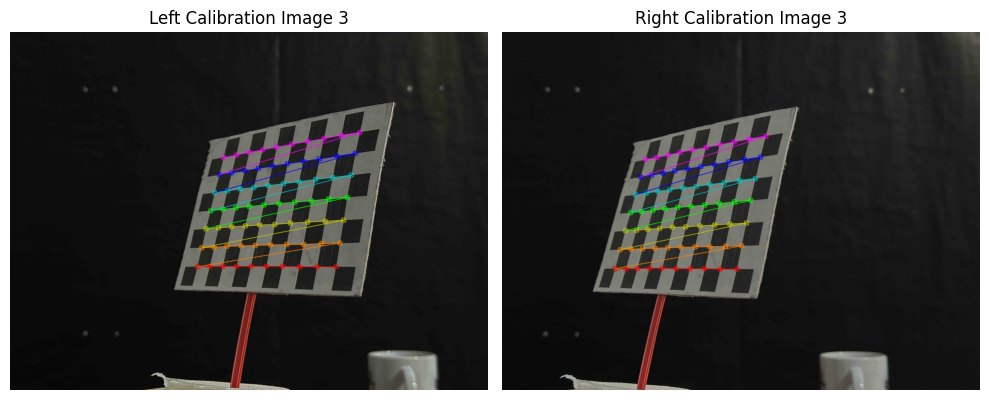

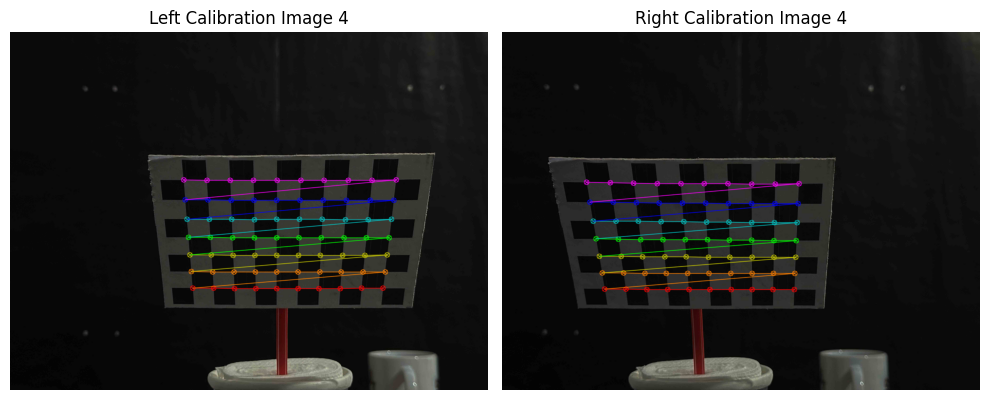

Error: Chessboard corners not found in calibration image pair 5.


error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'stereoCalibrate'
> Overload resolution failed:
>  - Can't parse 'objectPoints'. Sequence item with index 0 has a wrong type
>  - Can't parse 'objectPoints'. Sequence item with index 0 has a wrong type
>  - stereoCalibrate() missing required argument 'R' (pos 9)
>  - stereoCalibrate() missing required argument 'R' (pos 9)


In [28]:
# Load and resize calibration images
left_calib_images = []
right_calib_images = []
for i in range(0, len(calibration_filenames), 2):
    left_img_path = os.path.join(calibration_images_path, calibration_filenames[i])
    right_img_path = os.path.join(calibration_images_path, calibration_filenames[i+1])
    if os.path.exists(left_img_path) and os.path.exists(right_img_path):
        left_img = cv2.imread(left_img_path)
        right_img = cv2.imread(right_img_path)
        # Resize images
        left_img_resized = resize_image(left_img, scale_percent)
        right_img_resized = resize_image(right_img, scale_percent)
        left_calib_images.append(left_img_resized)
        right_calib_images.append(right_img_resized)
    else:
        print(f"Error: Calibration images {calibration_filenames[i]} or {calibration_filenames[i+1]} not found.")

# Camera calibration parameters
checkerboard_size = (10, 7)  # Internal corners per chessboard row and column
square_size = 12.5  # Size of a square in your defined unit (cm)

# Prepare object points
objp = np.zeros((checkerboard_size[0]*checkerboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:checkerboard_size[0], 0:checkerboard_size[1]].T.reshape(-1, 2)
objp *= square_size

# Arrays to store object points and image points
objpoints = []        # 3d point in real world space
imgpoints_left = []   # 2d points in image plane.
imgpoints_right = []

# Termination criteria for corner refinement
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Find chessboard corners and calibrate
for idx, (left_img, right_img) in enumerate(zip(left_calib_images, right_calib_images)):
    gray_left = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

    ret_left, corners_left = cv2.findChessboardCorners(gray_left, checkerboard_size, None)
    ret_right, corners_right = cv2.findChessboardCorners(gray_right, checkerboard_size, None)

    if ret_left and ret_right:
        objpoints.append(objp)

        # Refine corner locations
        corners_left = cv2.cornerSubPix(gray_left, corners_left, (11,11), (-1,-1), criteria)
        corners_right = cv2.cornerSubPix(gray_right, corners_right, (11,11), (-1,-1), criteria)

        imgpoints_left.append(corners_left)
        imgpoints_right.append(corners_right)

        # Optional: Draw and display the corners
        cv2.drawChessboardCorners(left_img, checkerboard_size, corners_left, ret_left)
        cv2.drawChessboardCorners(right_img, checkerboard_size, corners_right, ret_right)

        # Display the images with detected corners
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
        axs[0].set_title(f'Left Calibration Image {idx+1}')
        axs[0].axis('off')

        axs[1].imshow(cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB))
        axs[1].set_title(f'Right Calibration Image {idx+1}')
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print(f"Error: Chessboard corners not found in calibration image pair {idx+1}.")

# Check if sufficient valid pairs were found
if len(objpoints) < 1:
    print("Error: Not enough valid calibration images for stereo calibration.")
else:
    # Stereo calibration
    ret, cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T, E, F = cv2.stereoCalibrate(
        objpoints,
        imgpoints_left,
        imgpoints_right,
        None, None, None, None,
        gray_left.shape[::-1],
        criteria=criteria,
        flags=cv2.CALIB_FIX_INTRINSIC
    )

    # Stereo rectification
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
        cameraMatrix1, distCoeffs1,
        cameraMatrix2, distCoeffs2,
        gray_left.shape[::-1], R, T
    )

    # Save calibration data if needed
    calibration_data_path = '/content/drive/MyDrive/Research Files/Other files/Development/3D Construction/Our 3D Construction/Files/Preliminaries/calibration_data.pkl'
    with open(calibration_data_path, 'wb') as f:
        pickle.dump({
            'cameraMatrix1': cameraMatrix1,
            'distCoeffs1': distCoeffs1,
            'cameraMatrix2': cameraMatrix2,
            'distCoeffs2': distCoeffs2,
            'R': R, 'T': T, 'R1': R1, 'R2': R2, 'P1': P1, 'P2': P2, 'Q': Q
        }, f)

## Image Segmentation

### Segment plant objects

### Save segmented images

### Display segmented images

## Depth Map Generation

### Generate depth maps

### Save depth maps

### Display depth maps

## Point Cloud Generation

### Generate point clouds

### Save point clouds

### Display point clouds

## Point Cloud Registration

### Merge point clouds

### Save merged point cloud

### Display merged point cloud

## Mesh Generation

### Generate mesh from merged point cloud

### Save 3D mesh model

### Display 3D mesh model